<a href="https://colab.research.google.com/github/soheekim911/Standalone_DL/blob/master/assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time


## Data Preparation

In [90]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, 
                                        shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [91]:
print(len(trainset))
print(len(valset))
print(len(testset))

40000
10000
10000


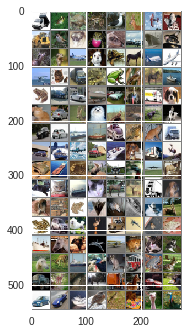

truck
frog
frog
frog
bird
deer
plane
cat
truck
bird
dog
frog
deer
plane
ship
dog
deer
bird
plane
dog
frog
horse
plane
plane
plane
cat
truck
frog
frog
bird
horse
ship
frog
truck
car
ship
car
bird
truck
dog
cat
car
deer
dog
bird
deer
deer
horse
car
car
ship
ship
car
frog
cat
truck
car
ship
plane
truck
ship
dog
truck
deer
frog
ship
frog
deer
plane
bird
plane
horse
cat
cat
ship
cat
horse
deer
truck
dog
dog
cat
frog
plane
dog
deer
ship
deer
frog
car
dog
deer
car
plane
cat
frog
ship
horse
cat
plane
plane
dog
cat
cat
horse
deer
ship
bird
cat
truck
frog
deer
truck
deer
frog
deer
truck
horse
car
bird
car
car
ship
bird
bird
cat
bird
bird
<class 'torch.Tensor'> torch.Size([128, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([128]) tensor([9, 6, 6, 6, 2, 4, 0, 3, 9, 2, 5, 6, 4, 0, 8, 5, 4, 2, 0, 5, 6, 7, 0, 0,
        0, 3, 9, 6, 6, 2, 7, 8, 6, 9, 1, 8, 1, 2, 9, 5, 3, 1, 4, 5, 2, 4, 4, 7,
        1, 1, 8, 8, 1, 6, 3, 9, 1, 8, 0, 9, 8, 5, 9, 4, 6, 8, 6, 4, 0, 2, 0, 7,
        3, 3, 8, 3, 7, 4, 9, 5,

In [92]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2  +0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
for i in range(len(images)):
    print(classes[labels[i]])
# print(' '.join('%30s'% classes[labels[j]] for j in range(4)))

print(type(images), images.shape)
print(type(labels), labels.shape, labels)

## Model Architecture

In [0]:
##### My Code ######

class MLP(nn.Module):   
    def __init__(self,in_dim,hid_dim,out_dim,n_layer,act):
        super(MLP, self).__init__() # super는 다중상속시 슈퍼 클래스의 method를 호출하라는 의미
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.n_layer = n_layer
        self.act = act
        
        # input --> act(output)
        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        # act(output) --> hid_dim을 가진 linear(fc) layer에 n-1번 통과
        self.linears = nn.ModuleList()
        # n-1번 fc layer를 통과
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        # out_dim은 최종 클래스 갯수대로
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        if self.act == 'relu':
            self.act = nn.ReLU()
            
    def forward(self, x):
        x = self.act(self.fc(x))
        for fc in self.linears: ### 여기 잘 이해 안 가..이렇게만 써도 레이어를 통과하게 되는 거야?
            x = self.act(fc(x)) 
        x = self.fc2(x)    
        return x
    
net = MLP(3072, 100, 10, 5, 'relu') # 3072 = 32*32(pixel)*3(RGB)
      

## Define Experiment

In [0]:
def experiment(args):
  
    net = MLP(args.in_dim, args.hid_dim, args.out_dim, args.n_layer, args.act)
    net.cuda()
#     print(net)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)
    
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        t_start = time.time()
        # ==== Train ===== #
        net.train()
        optimizer.zero_grad()
        
        running_loss = 0.0
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.view(-1, 3072)
            
            inputs = inputs.cuda()
            labels = labels.cuda()
            

            # zero the parameter gradients
            optimizer.zero_grad() # 왜 여기서 또 나오지??

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            train_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        list_epoch.append(epoch)   
        list_train_loss.append(train_loss)
        
        # ==== Validation ====== #
        net.eval()
        optimizer.zero_grad()
        
        correct = 0
        total = 0
        val_loss = 0 ########
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 3072)
                
                ################################
                images = images.cuda()
                labels = labels.cuda()
                
                outputs = net(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_loss = val_loss / len(valloader)
            val_acc = 100 * correct / total
            list_val_loss.append(val_loss)
        print('Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc))


    # ===== Evaluation ===== #
    net.eval()
    optimizer.zero_grad()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        list_acc.append(test_acc)
        list_acc_epoch.append(epoch)
    t_end = time.time()
    print('time spent: {}'.format(t_end-t_start))
    print(list_train_loss, list_val_loss)
    return train_loss, val_loss, val_acc, test_acc
    

In [97]:
##### My Code ######

import argparse

np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
print(type(args))

#### model related parameters ####
args.in_dim = 3072
args.hid_dim = 100
args.out_dim = 10
args.n_layer = 5

#### Hyperparameters ####
args.act = 'relu'
args.lr = 0.001
args.mm = 0.9
args.epoch = 3

layer_list = [3,4,5]
hid_dim_list = [50,100,150]

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

for layer in layer_list:
    for dim in hid_dim_list:
        args.n_layer = layer
        args.hid_dim = dim
        result = experiment(args)
        print(result)


<class 'argparse.Namespace'>
Epoch 0, Train Loss: 718.4838404655457, Val Loss: 2.2781264268899264, Val Acc: 16.21
Epoch 1, Train Loss: 702.5457305908203, Val Loss: 2.196911377242849, Val Acc: 19.7
Epoch 2, Train Loss: 663.583244562149, Val Loss: 2.0455130821541894, Val Acc: 25.95
time spent: -16.39527678489685
(663.583244562149, 2.0455130821541894, 25.95, 26.76)
Epoch 0, Train Loss: 716.0431571006775, Val Loss: 2.259309524222265, Val Acc: 16.03
Epoch 1, Train Loss: 686.204131603241, Val Loss: 2.1231741452518897, Val Acc: 22.49
Epoch 2, Train Loss: 643.3055664300919, Val Loss: 2.0090387048600595, Val Acc: 28.29
time spent: -16.198386430740356
(643.3055664300919, 2.0090387048600595, 28.29, 29.48)
Epoch 0, Train Loss: 715.5012757778168, Val Loss: 2.2590633585483215, Val Acc: 21.03
Epoch 1, Train Loss: 685.0886516571045, Val Loss: 2.111594918407971, Val Acc: 23.67
Epoch 2, Train Loss: 637.2816002368927, Val Loss: 1.9870776149291027, Val Acc: 28.75
time spent: -16.235544204711914
(637.28160

## Experiment

In [109]:
print(list_epoch)
print(list_train_loss)
print(list_val_loss)
print(list_acc)
print(list_acc_epoch)

[0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]
[718.4838404655457, 702.5457305908203, 663.583244562149, 716.0431571006775, 686.204131603241, 643.3055664300919, 715.5012757778168, 685.0886516571045, 637.2816002368927, 721.2688143253326, 718.9383387565613, 715.5292422771454, 719.786628484726, 715.6561961174011, 701.5076425075531, 719.8854279518127, 716.2080438137054, 704.1175994873047, 721.8385496139526, 720.5331976413727, 719.5170781612396, 721.1488587856293, 720.5819962024689, 720.1053557395935, 721.1143865585327, 720.4742543697357, 719.8597626686096]
[2.2781264268899264, 2.196911377242849, 2.0455130821541894, 2.259309524222265, 2.1231741452518897, 2.0090387048600595, 2.2590633585483215, 2.111594918407971, 1.9870776149291027, 2.3008092324944993, 2.292842569230478, 2.2772972281975083, 2.295247252983383, 2.27392411835586, 2.197103759910487, 2.2952077388763428, 2.277197822739806, 2.2100591900982436, 2.3044583163683927, 2.3009407731551157, 2.2972732978531

| THis | is |
|---------|-----|
|   a     |table|

In [0]:
!pip install tabletext
import tabletext

data = [[args.in_dim, args.hid_dim, args.lr],
       [124, 24, 43]]

print(tabletext.to_text(data))

ValueError: ignored

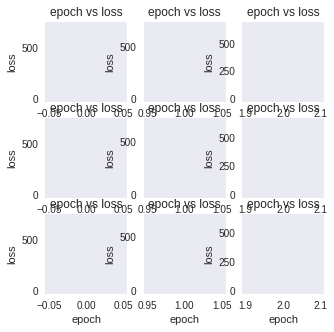

In [113]:

fig = plt.figure(figsize=(5,5))

for i in range(len(list_train_loss)):
    # ======== Loss ========== #
    ax1 = fig.add_subplot(3,3,i+1)
    ax1.plot(list_epoch[i], list_train_loss[i], label = 'train loss')
    ax1.plot(list_epoch[i], list_val_loss[i], label = 'validation loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.grid()
#     ax1.legend()
    ax1.set_title('epoch vs loss')

for j in range(len(list_acc)):
    # ======= Accuracy ======= #
    ax2 = fig.add_subplot(3,3,j+1)
    ax2.plot(list_acc_epoch[j], list_acc[j], marker='x', label = 'Accuracy metrics')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('Acc')
    ax2.grid()
#     ax2.legend()
    ax2.set_title('epoch vs Accuracy')


plt.show()